Data from:
Aagaard, K., Berggren, K., Hebert, P. D., Sones, J., McClenaghan, B., & Ekrem, T. (2017). Investigating suburban micromoth diversity using DNA barcoding of malaise trap samples. Urban Ecosystems, 20(2), 353-361.
https://link-springer-com.ezproxy.gc.cuny.edu/article/10.1007%2Fs11252-016-0597-2

In [7]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD/"
SIMOUT_DIR = GIMME_DIR + "sims_H_toobig/1d_sims/"
MICROMOTH_WORKDIR = "/home/isaac/Continuosity/MESS/empirical_micromoths/"
OBSERVED_FILE = os.path.join(MICROMOTH_WORKDIR, "micromoth.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "full-priors.txt")
FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "full-normed-priors.txt")

force = False
ONEPER = True
REGULARIZE = False
DROPEQUILIBSIMS = False

def construct_full_prior(outfile, ONEPER=False, REGULARIZE=False):
    outfile = open(outfile, "w")
    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## DO or don't regularlize the histograms
                if REGULARIZE:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = "\t".join(tmp) + "\n"

                ## Do or don't drop all the extra sims at equilibrium
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Only choose one step per simulation?
        if lines and ONEPER:
            lines = [random.choice(lines).strip()]

        ## Don't write blanks
        if lines:
            numsims += len(lines)
            lines[-1] = lines[-1].strip()
            outfile.write("".join(lines))
            outfile.write("\n")
    outfile.close()

    print("Processed {} simulations".format(numsims))

if not os.path.exists(FULL_REF_TABLE) or force:
    construct_full_prior(FULL_REF_TABLE, ONEPER=ONEPER)
#if not os.path.exists(FULL_NORMED_REF_TABLE) or force:
#    construct_full_prior(FULL_NORMED_REF_TABLE, ONEPER=ONEPER, REGULARIZE=True)

In [9]:
import sys
UNIF_FULL_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-priors.txt")
UNIF_FULL_NORMED_REF_TABLE = os.path.join(SIMOUT_DIR, "uniform-full-normed-priors.txt")

force = False

def uniform_lambda_prior(intable, outtable):
    dat = pd.read_csv(intable, sep="\t")

    ## Find min bin size
    gt_val = 0.01
    minct = len(dat[dat['%equil'] < gt_val])
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        ct = len(dat[lt & gt])
        if ct < minct:
            minct = ct
    print("min bin size {}".format(minct))

    gt_val = 0.01
    outdf = dat[dat['%equil'] < gt_val].sample(n=minct, replace=False)
    outdf = outdf[outdf["K"] > 6000]
    for lt_val in np.arange(0.02, 1.01, .01):
        gt = dat["%equil"] > gt_val
        lt = dat["%equil"] < lt_val
        gt_val = lt_val
        try:
            samps = dat[lt & gt]
            ## Watch this, it'll bite you with the replacement.
            tmpdf = samps.sample(n=minct, replace=False)
        except:
            print(lt_val, len(samps))
        outdf = pd.concat([outdf, tmpdf])
    #outdf
    _, _, _ = plt.hist(outdf["%equil"], bins=100)
    outdf.to_csv(outtable, sep="\t", index=False)
if not os.path.exists(UNIF_FULL_REF_TABLE) or force:
    uniform_lambda_prior(FULL_REF_TABLE, UNIF_FULL_REF_TABLE)
#if not os.path.exists(UNIF_FULL_NORMED_REF_TABLE) or force:
#    uniform_lambda_prior(FULL_NORMED_REF_TABLE, UNIF_FULL_NORMED_REF_TABLE)

In [10]:
%%R -i OBSERVED_FILE -i UNIF_FULL_NORMED_REF_TABLE -i UNIF_FULL_REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## Do or don't regularize the observed pi bins
if(FALSE){
    tot = sum(OBS)
    OBS = data.frame(c(OBS/tot))
    PRIOR <- read.table(UNIF_FULL_NORMED_REF_TABLE, header=TRUE, fill=TRUE)
} else {
    PRIOR <- read.table(UNIF_FULL_REF_TABLE, header=TRUE, fill=TRUE)
}

## fill adds NA for any incomplete row

print(PRIOR[1,])
print(OBS)


      K           c   step     X.equil      colrate      extrate shannon bin_0
1 12839 0.001185339 130000 0.007477218 0.0005923077 0.0004769231 2.49114     2
  bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     4     1     3     2     2     0     1     0     2
  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1    59    15    14     3     5     1     2     1     1     1


Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS, param = data.frame(shan = PRIOR[, "shannon"], 
    eq = PRIOR[, "X.equil"], c = PRIOR[, "colrate"], e = PRIOR[, 
        "extrate"], k = PRIOR[, "K"]), sumstat = PRIOR[, 8:17], 
    tol = 0.001, method = "rejection", hcorr = FALSE)
Data:
 abc.out$unadj.values (392 posterior samples)

                  shan        eq         c         e         k
Min.:           2.5564    0.1468    0.0019    0.0019 1115.0000
2.5% Perc.:     2.8646    0.3064    0.0019    0.0019 1658.0000
Median:         3.2009    0.7756    0.0020    0.0020 5849.0000
Mean:           3.2091    0.7359    0.0028    0.0028 5284.5995
Mode:           3.1606    0.8449    0.0020    0.0020 5878.7627
97.5% Perc.:    3.5745    0.9767    0.0090    0.0086 5916.0000
Max.:           3.7981    0.9994    0.0173    0.0166 5916.0000
                     shan           eq            c            e            k
Min.:        2.556396e+00 1.467615e-01 1.925833e-03 1.896667e-03 1.115000e+03
2.5% Perc.:  2.864597e+00 3.06

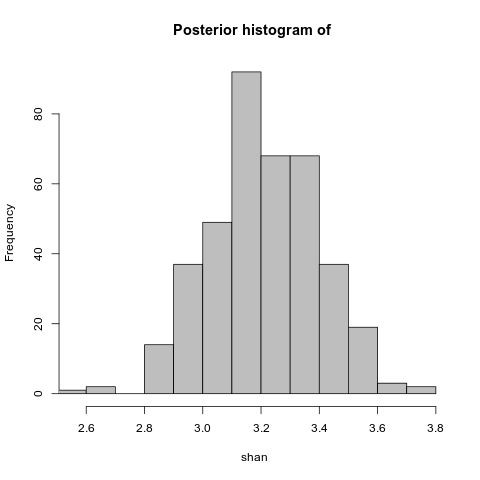

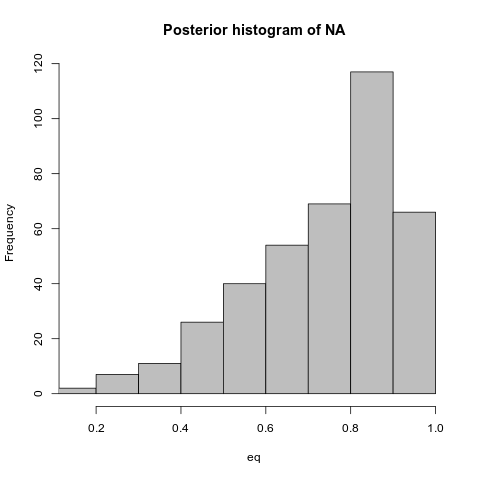

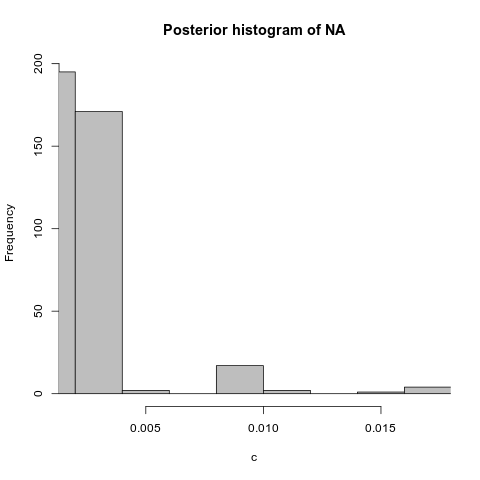

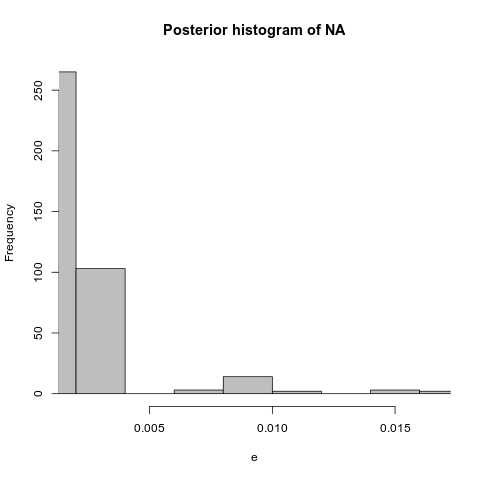

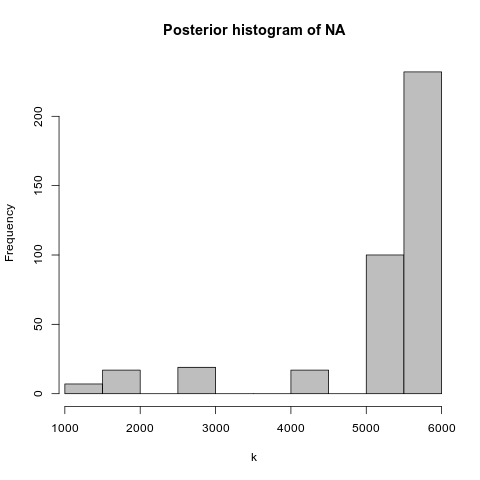

In [19]:
%%R
res_joint.abc = abc(target=OBS, param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], e=PRIOR[,"extrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,8:17], hcorr=FALSE, tol=0.001, method="rejection")
print(summary(res_joint.abc))
hist(res_joint.abc, cap="", breaks=10)

In [17]:
%%R
print(OBS)
print(res_joint.abc$ss)
print(res_joint.abc)

  bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1    59    15    14     3     5     1     2     1     1     1
       bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,]    59    10     1     1     0     0     0     0     0     0
  [2,]    57    12     1     0     0     0     1     0     0     0
  [3,]    58    13     1     0     0     0     0     0     0     0
  [4,]    60    12     2     0     0     0     0     0     0     0
  [5,]    56    15     1     0     0     0     0     0     0     0
  [6,]    65    18     1     0     1     0     0     0     0     0
  [7,]    57    13     1     0     0     0     0     0     0     0
  [8,]    56     9     2     1     0     0     0     0     0     0
  [9,]    54    13     2     1     0     0     0     0     0     0
 [10,]    58    16     1     1     0     0     0     0     0     0
 [11,]    60    10     2     0     0     0     0     0     0     0
 [12,]    54    12     2     0     0     0     0     0     0     0
 [13,

 abc.out$unadj.values (432 posterior samples)

                shan        eq         c         k
Min.:           2.1287    0.0124    0.0003 3635.0000
2.5% Perc.:     2.4551    0.0232    0.0004 6007.3500
Median:         2.9528    0.7699    0.0006 8499.0000
Mean:           2.9432    0.6421    0.0007 7770.6921
Mode:           2.9521    0.9253    0.0005 6533.7908
97.5% Perc.:    3.3131    0.9916    0.0015 9643.0000
Max.:           3.5425    0.9987    0.0023 9643.0000

[59 15 14  3  5  1  2  1  1  1]
[[59. 10.  1.  1.  0.  0.  0.  0.  0.  0.]
 [57. 12.  1.  0.  0.  0.  1.  0.  0.  0.]
 [58. 13.  1.  0.  0.  0.  0.  0.  0.  0.]
 [60. 12.  2.  0.  0.  0.  0.  0.  0.  0.]
 [56. 15.  1.  0.  0.  0.  0.  0.  0.  0.]
 [65. 18.  1.  0.  1.  0.  0.  0.  0.  0.]
 [57. 13.  1.  0.  0.  0.  0.  0.  0.  0.]
 [56.  9.  2.  1.  0.  0.  0.  0.  0.  0.]
 [54. 13.  2.  1.  0.  0.  0.  0.  0.  0.]
 [58. 16.  1.  1.  0.  0.  0.  0.  0.  0.]]
explained variance ratio (first two components): [0.5657722  0.35513823]


[]

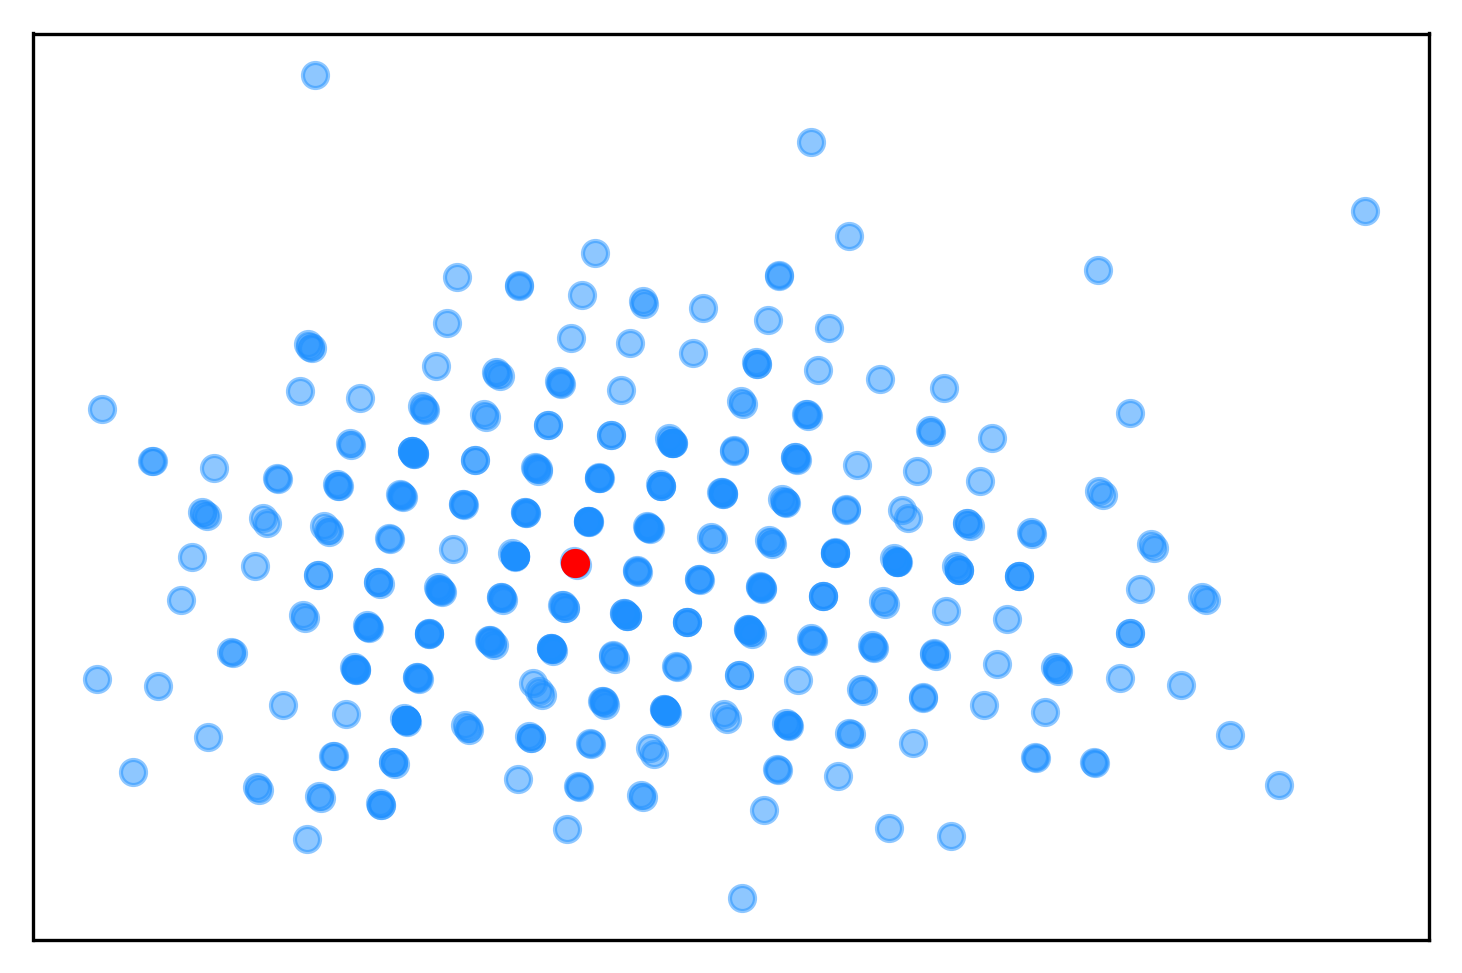

In [20]:
%R -o out out=res_joint.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()])
print(OBS)
print(out[0:10])

dat = np.vstack([out, OBS])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])